In [1]:
import sys
import os
sys.path.append('../')
sys.path.append('../wdtools')
sys.path.append('../WD_models')

### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
import WD_models

In [2]:
c1 = Table.read('data/02_wd_rv.fits')
c2 = Table.read('data/03_photometry.fits')

catalog = join(c1, c2, keys='wd_source_id', join_type='inner')

In [3]:
#c1[['wd_source_id', 'wd_catalog_id']].pprint(200, 200)
#c2[['wd_source_id', 'phot_id']].pprint(400, 400)

In [4]:
print(len(catalog))

39


In [5]:
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

def rv_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_5917/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_5917/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_5917/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


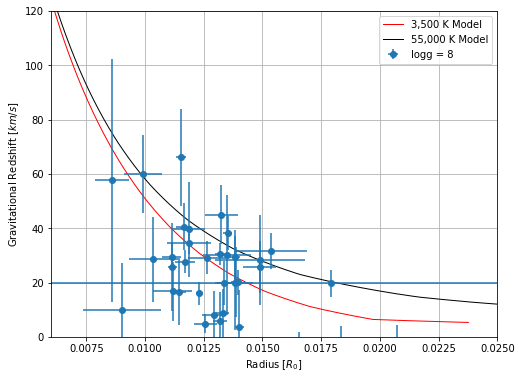

In [6]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog['radius'], catalog['g_redshift'], xerr = catalog['e_radius'], yerr=catalog['eg_redshift'], fmt='o', label = 'logg = 8')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()
#plt.savefig('plots/photometry/gredshift_vs_radius.jpg')

In [7]:
print(catalog[['clean', 'insideMask']])

clean = catalog['clean']

clean insideMask
----- ----------
    1          0
    1          0
    1          0
    0          2
    0          0
    0          0
    1          0
    1          0
    1          0
    0          0
    0          0
  ...        ...
    1          0
    1          0
    1          0
    1          0
    1          0
    1          0
    1          0
    1          0
    1         16
    1          0
    1          0
Length = 39 rows


Text(0.5, 0, '$RV_{MS} - RV_{WD}$')

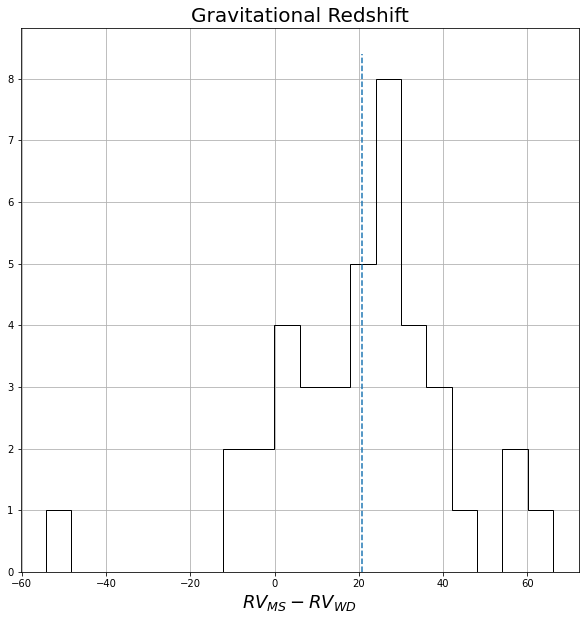

In [8]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['g_redshift'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['g_redshift']), ymin, ymax, linestyles='dashed')
plt.title('Gravitational Redshift', fontsize=20)
plt.xlabel(r'$RV_{MS} - RV_{WD}$', fontsize=18)

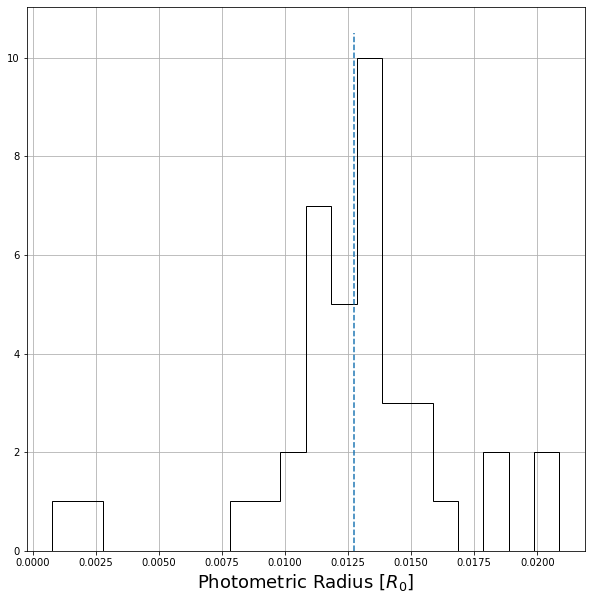

In [9]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['radius'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['radius']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_{0}]$', fontsize=18)
plt.savefig('plots/photometry/cleaned_radius.png')

In [10]:
rechi = np.all([catalog['rechi'] < 3.5], axis = 0)
redchi = np.all([catalog['redchi'] < 3.5], axis = 0)


In [11]:
mask = np.all([clean], axis = 0)
#mask = np.all([clean, photomask, redchi_mask, rechi_mask, e_redshift_mask], axis = 0)
#mask = np.all([clean, photomask], axis = 0)
#mask = np.all([clean, radius_mask, redshift_mask], axis = 0)
#mask = np.all([clean, photomask, redchi_mask, rechi_mask, radius_mask, redshift_mask], axis = 0)
print(mask)

[ True  True  True False False False  True  True  True False False False
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]


wd_catalog_id        radius               e_radius            g_redshift        eg_redshift    
------------- -------------------- ---------------------- ------------------ ------------------
           46 0.011880705408930893  0.0009312900305083172 34.634896464446555  4.225469813553133
           64 0.010359992240246415  0.0010276255658144523  28.62776224701238  15.68205206056922
           65  0.01401605680547447  0.0002027534268423504 3.5318611035456087 13.798956734519411
           10 0.011433860642687277  0.0002994424857915555 16.580447673990044 12.341585515575144
            9  0.01351412570592664 0.00019333544394583137  38.21075112329969  6.183631580219448
           11 0.011536172290105054 0.00020720450326221782  66.12243194870925  17.88413521356123
            0 0.012950660832499314  0.0005047892968963372  7.937203479695162  8.961385164347877
           22 0.011131156869991962  0.0004129254399094292 29.567096712103478  5.234424251237261
           63 0.013207792893690656  0.00

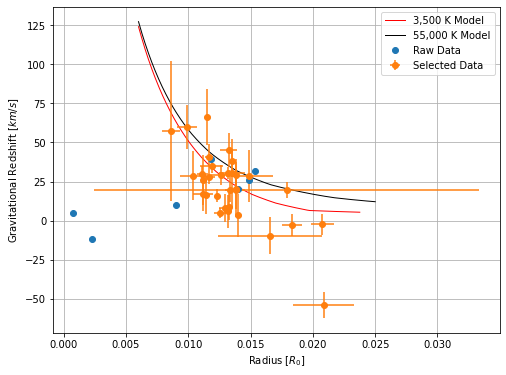

In [12]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.025)
#plt.ylim(0, 120)
plt.legend()

print(catalog[['wd_catalog_id', 'radius', 'e_radius', 'g_redshift', 'eg_redshift']][mask])

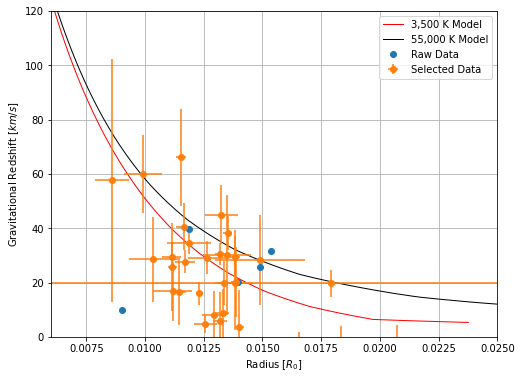

In [13]:
from scipy.optimize import curve_fit

def exp(x, A, B, C):
    return A*x**B+C

#popt, pcov = curve_fit(exp, catalog['radius'][mask], catalog['g_redshift'][mask], 
#                       sigma = catalog['eg_redshift'][mask], p0 = [1, 1, 1])

#print(popt)

plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.plot(rsuns, exp(rsuns, popt[0], popt[1], popt[2]))
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()

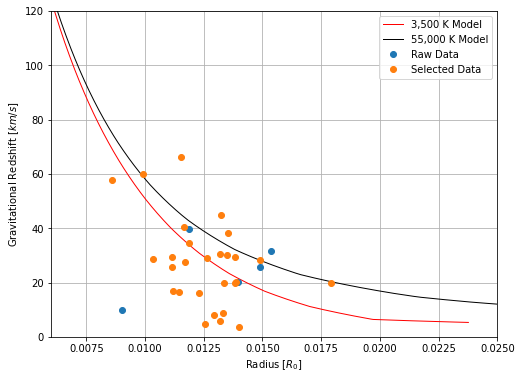

In [14]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], fmt='o', label = 'Selected Data')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()

In [15]:
#catalog = catalog[mask == 1]
print(len(catalog))

39


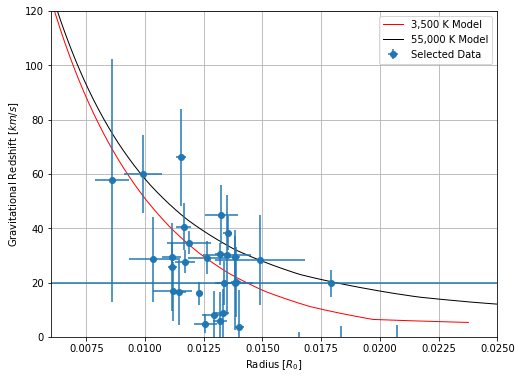

In [16]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr = catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()

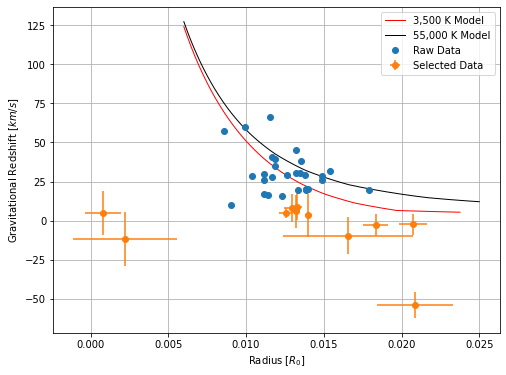

In [17]:
investigative = np.all([catalog['g_redshift'] < 10], axis = 0)

plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][~investigative], catalog['g_redshift'][~investigative], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][investigative], catalog['g_redshift'][investigative], xerr = catalog['e_radius'][investigative], yerr=catalog['eg_redshift'][investigative], fmt='o', label = 'Selected Data')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.025)
#plt.ylim(0, 120)
plt.legend()

In [18]:
print(catalog[['wd_catalog_id', 'rv','g_redshift', 'radius', 'R_chance_align']][np.logical_and(investigative, mask)])

wd_catalog_id          rv              g_redshift            radius            R_chance_align    
------------- ------------------- ------------------- -------------------- ----------------------
           65 -16.370465480316696  3.5318611035456087  0.01401605680547447     0.0006199301301292
            0   8.836032701420626   7.937203479695162 0.012950660832499314      0.035244081871421
           47 0.16151229018984814  4.9167079078656295 0.012575323301880579  7.300629160959902e-06
           17  23.015079448443437  -2.817264606732344 0.018335127360932835     0.0001374949264793
           43   35.17463283547116    8.94385318764401 0.013299260909193322     0.0006214070251626
           41  -46.26236764579259 -2.4161457219644618 0.020737955274498683     0.0001890345894708
           26  -23.49866170993451  -9.832774830967224 0.016561011089003694 2.6279332871127716e-05
           24  12.269650588136091   5.877794871430769 0.013186636646201422     0.0002441559232451
           13  -62.6

In [19]:
catalog[['wd_catalog_id', 'rv','g_redshift', 'radius', 'R_chance_align']][mask].pprint(100, 100)

'''
radii: 23, 30, 31, 63, 68, 74, 83
corv: 26, 68, 73, 74
'''

oldmask = mask.copy()

badstars = [23, 30, 31, 63, 68, 74, 83, 26, 73]

for i in range(len(mask)):
    if (mask[i] != 0) and (catalog['wd_catalog_id'][i] in badstars):
        mask[i] = 0

wd_catalog_id          rv              g_redshift            radius            R_chance_align    
------------- ------------------- ------------------- -------------------- ----------------------
           46   58.00071258077956  34.634896464446555 0.011880705408930893  7.591392913432326e-05
           64  29.938830305026297   28.62776224701238 0.010359992240246415     0.0186591087042385
           65 -16.370465480316696  3.5318611035456087  0.01401605680547447     0.0006199301301292
           10  40.805390835000786  16.580447673990044 0.011433860642687277  3.952209660670122e-07
            9   62.26655823694715   38.21075112329969  0.01351412570592664 1.8647269808828277e-05
           11   99.29513473801589   66.12243194870925 0.011536172290105054     0.0016200695317953
            0   8.836032701420626   7.937203479695162 0.012950660832499314      0.035244081871421
           22   29.97117719244062  29.567096712103478 0.011131156869991962  4.181233891997112e-06
           63   38.6

In [20]:
catalog[['wd_catalog_id', 'rv','g_redshift', 'radius', 'R_chance_align']][mask].pprint(100, 100)


wd_catalog_id          rv              g_redshift            radius            R_chance_align    
------------- ------------------- ------------------- -------------------- ----------------------
           46   58.00071258077956  34.634896464446555 0.011880705408930893  7.591392913432326e-05
           64  29.938830305026297   28.62776224701238 0.010359992240246415     0.0186591087042385
           65 -16.370465480316696  3.5318611035456087  0.01401605680547447     0.0006199301301292
           10  40.805390835000786  16.580447673990044 0.011433860642687277  3.952209660670122e-07
            9   62.26655823694715   38.21075112329969  0.01351412570592664 1.8647269808828277e-05
           11   99.29513473801589   66.12243194870925 0.011536172290105054     0.0016200695317953
            0   8.836032701420626   7.937203479695162 0.012950660832499314      0.035244081871421
           22   29.97117719244062  29.567096712103478 0.011131156869991962  4.181233891997112e-06
           67  23.40

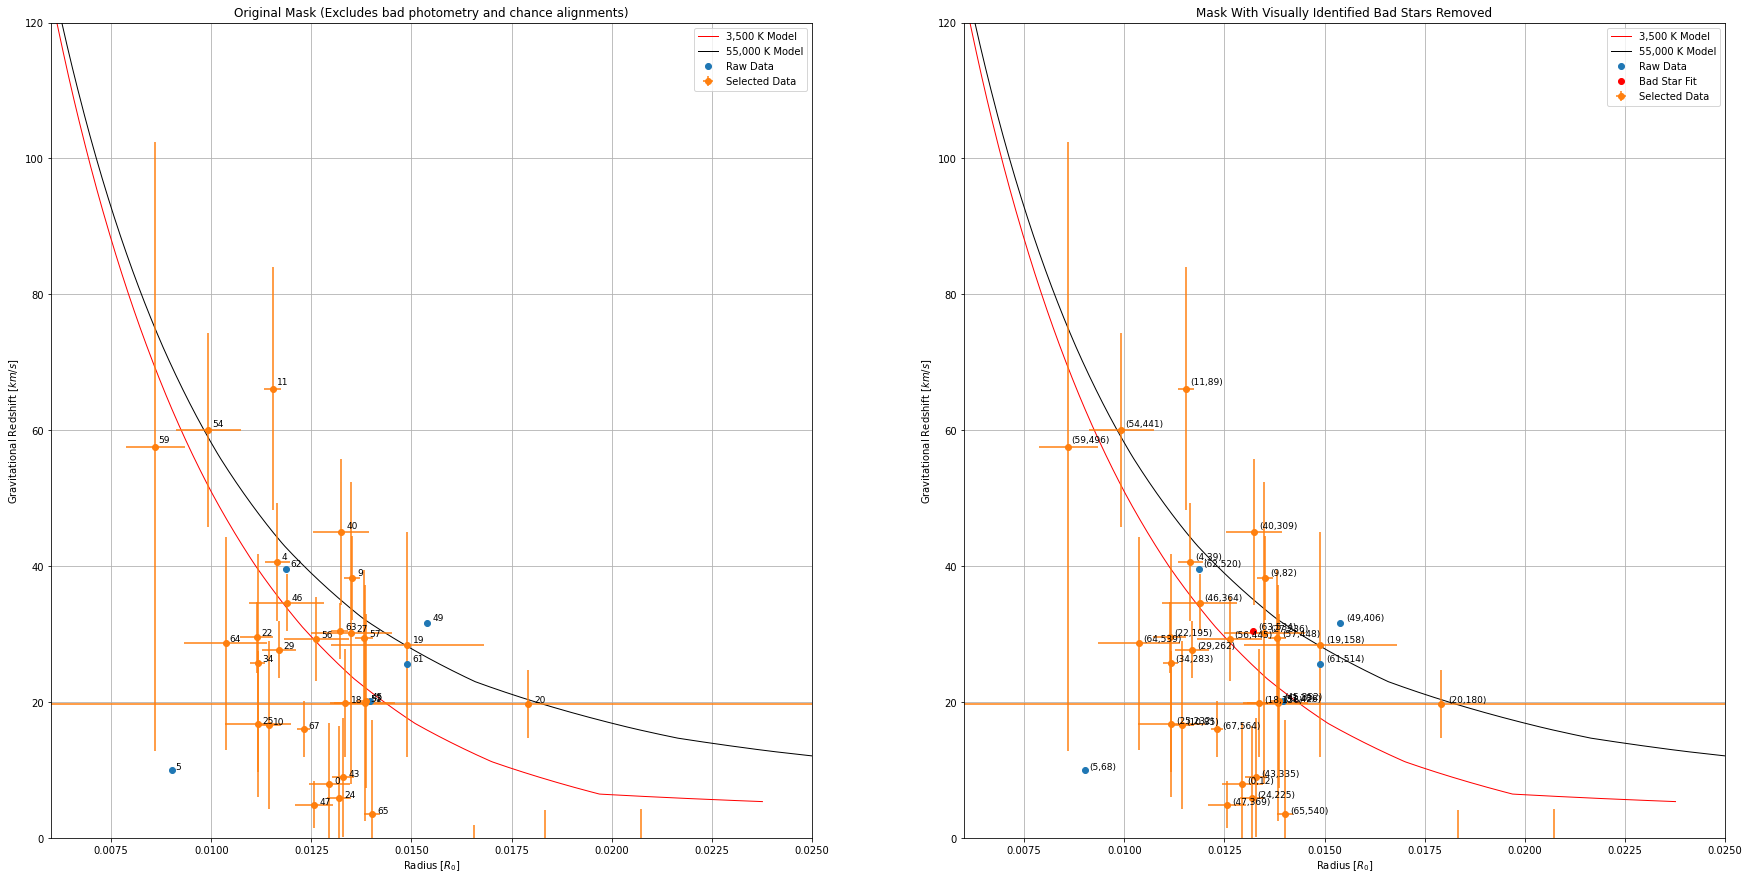

In [21]:
plt.figure(figsize=(30,15))

plt.subplot(1,2,1)

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.plot(rsuns, exp(rsuns, popt[0], popt[1], popt[2]))
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][~oldmask], catalog['g_redshift'][~oldmask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][oldmask], catalog['g_redshift'][oldmask], xerr = catalog['e_radius'][oldmask], yerr=catalog['eg_redshift'][oldmask], fmt='o', label = 'Selected Data')

for i in range(len(catalog['radius'])):
    x = catalog['radius'][i]
    y = catalog['g_redshift'][i]
    #plt.plot(x, y, 'bo')
    
    if (0.006 < x < 0.025) and (0 < y < 120):
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][i], fontsize=9)

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.title('Original Mask (Excludes bad photometry and chance alignments)')
plt.legend()

plt.subplot(1,2,2)

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.plot(rsuns, exp(rsuns, popt[0], popt[1], popt[2]))
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][~oldmask], catalog['g_redshift'][~oldmask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][np.logical_and(oldmask, ~mask)], catalog['g_redshift'][np.logical_and(oldmask, ~mask)], fmt='o', label = 'Bad Star Fit', color = 'Red')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

for i in range(len(catalog['radius'])):
    x = catalog['radius'][i]
    y = catalog['g_redshift'][i]
    #plt.plot(x, y, 'bo')
    
    if (0.006 < x < 0.025) and (0 < y < 120):
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , '(' + str(catalog['wd_catalog_id'][i]) + ',' + str(int(catalog['phot_id'][i])) + ')', fontsize=9)

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.title('Mask With Visually Identified Bad Stars Removed')
plt.legend()

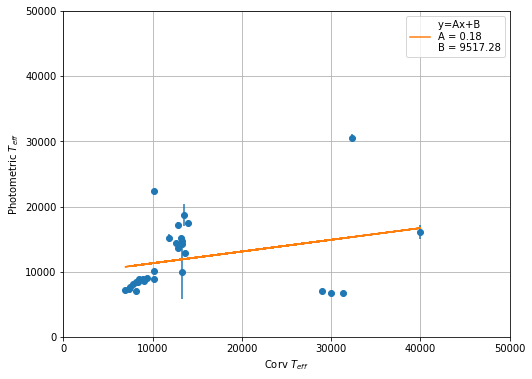

In [22]:
def linear(x, m, b):
    return m*x+b

def linear(x, A, B):
    return A*x+B

popt, pcov = curve_fit(linear, catalog['corv_teff'][mask], catalog['phot_teff'][mask], sigma = catalog['e_teff'][mask])

plt.figure(figsize=(8,6))

plt.errorbar(catalog['corv_teff'][mask], catalog['phot_teff'][mask], xerr = catalog['e_teff'][mask], yerr=catalog['e_phot_teff'][mask], fmt='o')
plt.plot(catalog['corv_teff'], linear(catalog['corv_teff'], popt[0], popt[1]), label=("y=Ax+B \nA = {:2.2} \nB = {:2.2f}".format(popt[0], popt[1])))

plt.grid()
plt.xlabel(r'Corv $T_{eff}$')
plt.ylabel(r'Photometric $T_{eff}$')
plt.xlim(0, 50000)
plt.ylim(0, 50000)
plt.legend()
#plt.savefig('plots/photometry/cleaned_gredshift_vs_radius.jpg')

In [23]:
from astroquery.gaia import Gaia


ADQL_CODE1 = "SELECT source_id, grvs_mag, grvs_mag_error, grvs_mag_nb_transits, rv_template_teff, rv_template_logg, rv_template_fe_h \
    FROM gaiadr3.gaia_source \
    WHERE gaia_source.source_id IN {}\
    AND radial_velocity is not null\
    AND radial_velocity_error < 2\
".format(tuple(catalog['ms_source_id']))

job1 = Gaia.launch_job(ADQL_CODE1,dump_to_file=False)
d1 = job1.get_results()



In [24]:
grvs = []
grvs_err = []
grvs_nb_transit = []
teff = []
logg = []
fe_h = []

for i in tqdm (range(len(catalog))):
    notfound = False
    a = np.where(catalog['ms_source_id'][i] == d1['source_id'])
    
    try:
        j = a[0][0]
    except:
        notfound = True
        
    if not notfound: 
        grvs.append(d1['grvs_mag'][j])
        grvs_err.append(d1['grvs_mag_error'][j])
        grvs_nb_transit.append(d1['grvs_mag_nb_transits'][j])
        teff.append(d1['rv_template_teff'][j])
        logg.append(d1['rv_template_logg'][j])
        fe_h.append(d1['rv_template_fe_h'][j])
    else:
        drops.append(i)   

catalog['ms_grvs_mag'] = grvs
catalog['ms_grvs_mag_err'] = grvs_err
catalog['ms_grvs_mag_nb_transit'] = grvs_nb_transit
catalog['ms_teff'] = teff
catalog['ms_logg'] = logg
catalog['ms_fe_h'] = fe_h

100%|██████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 253.71it/s]


In [25]:
ms_rv_corr = []

for i in tqdm(range(len(catalog))):
    if catalog['ms_grvs_mag'][i] >= 11:
        ms_rv_corr.append(catalog['ms_rv'][i] - (0.02755 * catalog['ms_grvs_mag'][i]**2 - 0.55863 * catalog['ms_grvs_mag'][i] + 2.81129))
    else:
        ms_rv_corr.append(catalog['ms_rv'][i])
        
    
    
catalog['ms_rv_corr'] = ms_rv_corr    
    
catalog['g_redshift_corr'] = catalog['rv'] - catalog['ms_rv_corr']
catalog['eg_redshift_corr'] = catalog['ms_erv'] + catalog['e_rv']

100%|████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 18041.01it/s]


In [26]:
catalog[['wd_catalog_id', 'ms_phot_g_mean_mag', 'ms_grvs_mag', 'ms_rv', 'ms_rv_corr']][mask].pprint(100, 100)

wd_catalog_id ms_phot_g_mean_mag ms_grvs_mag    ms_rv         ms_rv_corr    
------------- ------------------ ----------- ----------- -------------------
           46          13.500139   11.979933   23.365816  23.292933316376693
           64          11.226004   10.699749    1.311068   1.311068058013916
           65          10.498468     9.93408  -19.902327 -19.902326583862305
           10          13.877137   12.215872   24.224943   24.12658734176791
            9          12.357327   11.386491   24.055807   24.03343510880448
           11           10.47657    9.981813   33.172703   33.17270278930664
            0            9.56292    8.859813   0.8988292  0.8988292217254639
           22           13.89525   12.127975  0.40408048  0.3155728308401362
           67          12.280472  10.7588215   7.3839808   7.383980751037598
           51           10.37624    9.736457   28.583397  28.583396911621094
           57          12.847945   11.946408 -0.59335405 -0.6628662684025244

In [27]:
is_not_giant = np.ones(len(catalog))

for i in range(len(catalog)):
    if catalog['ms_m_g'][i] < (2 * catalog['ms_bp_rp'][i] + 0.5):
        is_not_giant[i] = 1
        
catalog['is_not_giant'] = is_not_giant
catalog['pairdistance_arcsec'] = catalog['pairdistance'] * 3600

In [28]:
catalog[['wd_catalog_id', 'phot_id', 'ms_phot_g_mean_mag', 'ms_grvs_mag', 'ms_rv', 'ms_rv_corr', 'is_not_giant', 'pairdistance_arcsec']][mask].pprint(200, 200)

wd_catalog_id phot_id ms_phot_g_mean_mag ms_grvs_mag    ms_rv         ms_rv_corr     is_not_giant pairdistance_arcsec
------------- ------- ------------------ ----------- ----------- ------------------- ------------ -------------------
           46   364.0          13.500139   11.979933   23.365816  23.292933316376693          1.0   78.61900554726408
           64   539.0          11.226004   10.699749    1.311068   1.311068058013916          1.0  52.154813585262964
           65   540.0          10.498468     9.93408  -19.902327 -19.902326583862305          1.0   21.35820153139092
           10    85.0          13.877137   12.215872   24.224943   24.12658734176791          1.0  14.841908759480399
            9    82.0          12.357327   11.386491   24.055807   24.03343510880448          1.0  31.053904155537836
           11    89.0           10.47657    9.981813   33.172703   33.17270278930664          1.0   66.27333246521327
            0    12.0            9.56292    8.859813   0

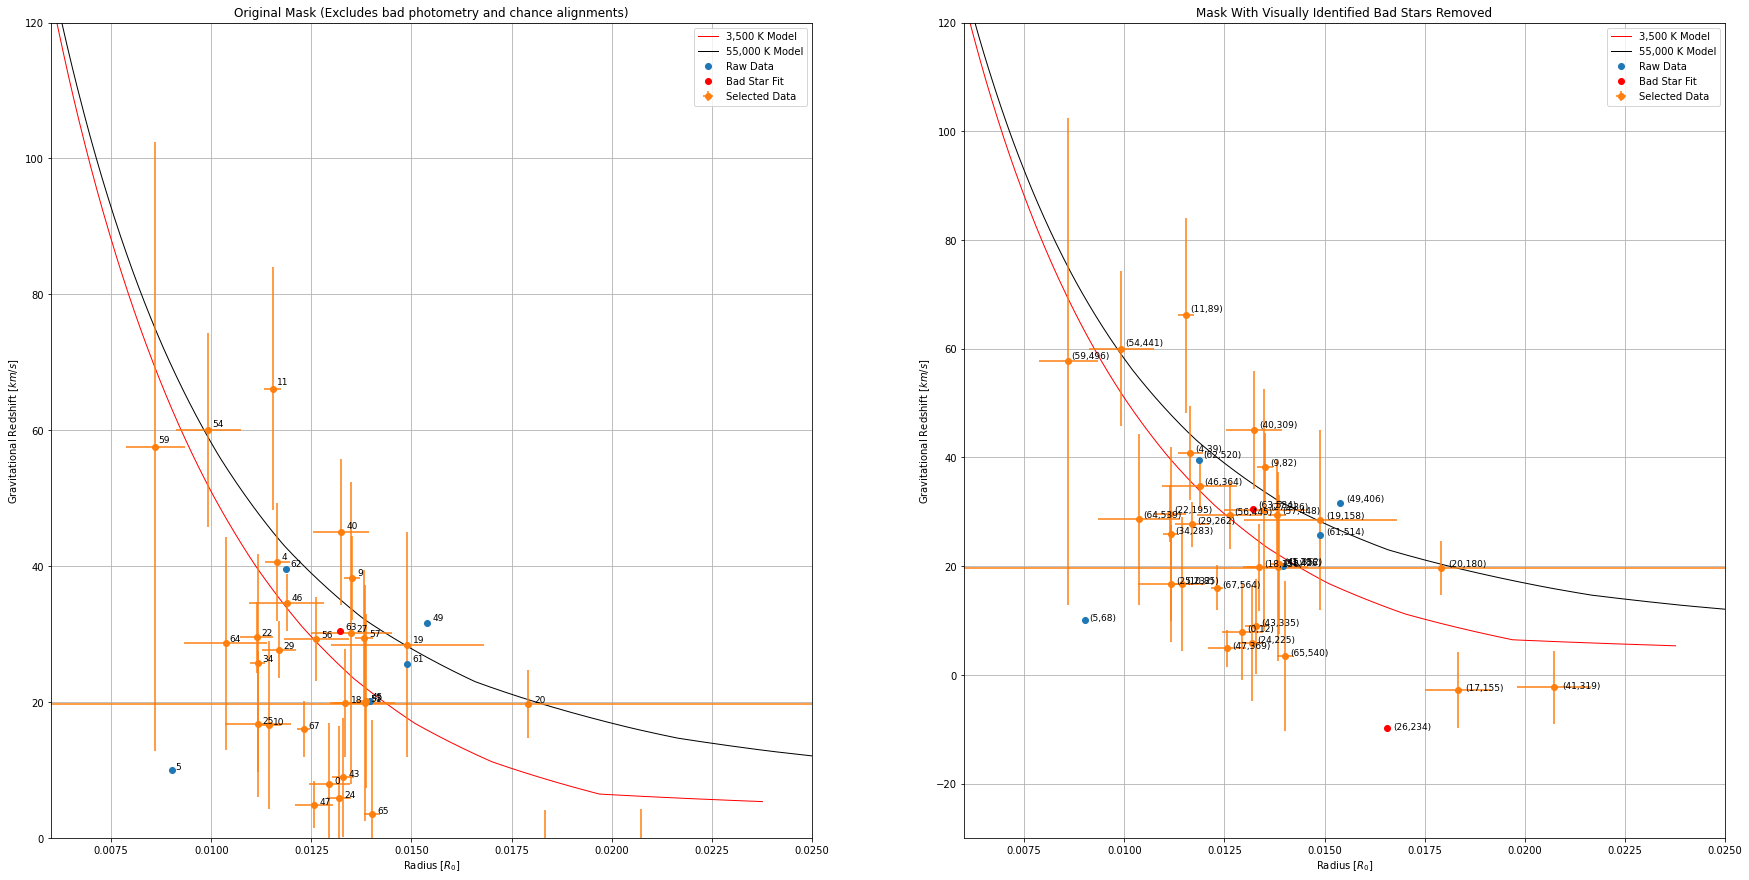

In [29]:
plt.figure(figsize=(30,15))

plt.subplot(1,2,1)

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog['radius'][~oldmask], catalog['g_redshift'][~oldmask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][np.logical_and(oldmask, ~mask)], catalog['g_redshift'][np.logical_and(oldmask, ~mask)], fmt='o', label = 'Bad Star Fit', color = 'Red')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

for i in range(len(catalog['radius'])):
    x = catalog['radius'][i]
    y = catalog['g_redshift'][i]
    #plt.plot(x, y, 'bo')
    
    if (0.006 < x < 0.025) and (0 < y < 120):
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][i], fontsize=9)

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.title('Original Mask (Excludes bad photometry and chance alignments)')
plt.legend()

plt.subplot(1,2,2)

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.plot(rsuns, exp(rsuns, popt[0], popt[1], popt[2]))
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][~oldmask], catalog['g_redshift_corr'][~oldmask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][np.logical_and(oldmask, ~mask)], catalog['g_redshift_corr'][np.logical_and(oldmask, ~mask)], fmt='o', label = 'Bad Star Fit', color = 'Red')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift_corr'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Selected Data')

for i in range(len(catalog['radius'])):
    x = catalog['radius'][i]
    y = catalog['g_redshift'][i]
    #plt.plot(x, y, 'bo')
    
    if (0.006 < x < 0.025) and (-30 < y < 120):
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , '(' + str(catalog['wd_catalog_id'][i]) + ',' + str(int(catalog['phot_id'][i])) + ')', fontsize=9)

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(-30, 120)
plt.title('Mask With Visually Identified Bad Stars Removed')
plt.legend()

wd_catalog_id phot_id      g_redshift            radius                 rv            ms_rv     ms_bp_rp  ms_teff ms_logg ms_fe_h     corv_logg          corv_teff     
------------- ------- ------------------- -------------------- ------------------- ----------- ---------- ------- ------- ------- ------------------ ------------------
           46   364.0  34.634896464446555 0.011880705408930893   58.00071258077956   23.365816  2.1186981  3800.0     4.5     0.0  8.199508406493106  8447.965883781384
           64   539.0   28.62776224701238 0.010359992240246415  29.938830305026297    1.311068 0.60267544  6500.0     4.0     0.0   8.19021939099412  13544.28149525842
           65   540.0  3.5318611035456087  0.01401605680547447 -16.370465480316696  -19.902327 0.66287804  6000.0     3.5     0.0  8.900236390387304 13908.341938902398
           10    85.0  16.580447673990044 0.011433860642687277  40.805390835000786   24.224943  2.5025024  3300.0     3.5   -0.75  4.735879806686443 28999.96317

Text(0.5, 0, 'RV Discrepancy $[km/s]$')

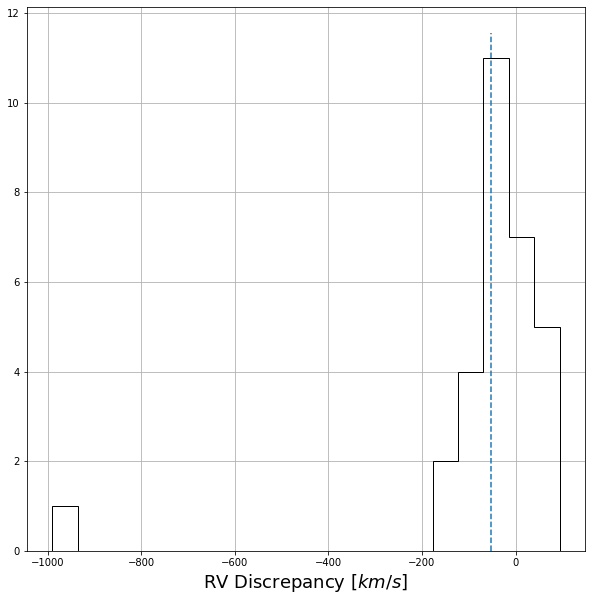

In [30]:
catalog['rv_theory'] = rv_from_radius(catalog['radius'], catalog['ms_teff'], 'f', 'f', 'f')
catalog['pct_err'] = (catalog['g_redshift'] - catalog['rv_theory']) / catalog['rv_theory'] * 100

catalog[['wd_catalog_id', 'phot_id', 'g_redshift', 'radius', 'rv', 'ms_rv', 'ms_bp_rp', 'ms_teff', 'ms_logg', 'ms_fe_h', 'corv_logg', 'corv_teff']][mask].pprint(100, 200)

tempmask = mask.copy()

for i in range(len(mask)):
    if catalog['pct_err'][i] < -200:
        tempmask[i] = 0
    
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['pct_err'][mask], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['pct_err'][mask]), ymin, ymax, linestyles='dashed')
plt.xlabel(r'RV Discrepancy $[km/s]$', fontsize=18)

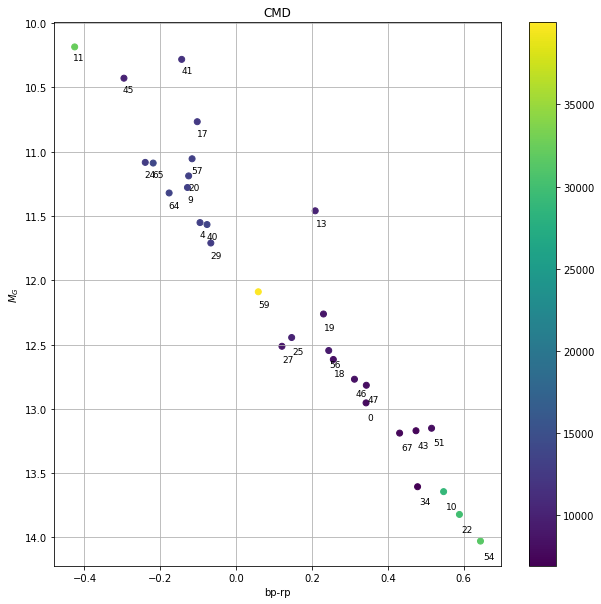

In [31]:
plt.figure(figsize=(10,10))

#plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], label='Main Sequence', s=5)
#plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5)
plt.scatter(catalog['wd_bp_rp'][mask], catalog['wd_m_g'][mask], label='White Dwarf', c = catalog['corv_teff'][mask])
#plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], label='Main Sequence')

#plt.plot([catalog['wd_bp_rp'][mask], catalog['ms_bp_rp'][mask]], [catalog['wd_m_g'][mask], catalog['ms_m_g'][mask]], 'bo', linestyle="--", alpha = 0.3)


for i in range(len(catalog['wd_bp_rp'][mask])):
    x = catalog['wd_bp_rp'][mask][i]
    y = catalog['wd_m_g'][mask][i]
    #plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][mask][i], fontsize=9)


plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

#plt.plot(np.linspace(xmin, xmax, num=100), wd_sep(np.linspace(xmin, xmax, num=100)))

plt.colorbar()

In [32]:
from astroquery.sdss import SDSS

wl = []
fl = []
ivar = []

epoch_wls = []
epoch_fls = []
epoch_ivars = []

for i in tqdm(range(len(catalog))):
    t_wl = []
    t_fl = []
    t_ivar = []
    
    spec = SDSS.get_spectra_async(plate=catalog['plate'][i], fiberID=catalog['fiber'][i], mjd=catalog['mjd'][i])[0].get_fits()
    
    #print(spec[4].header)
    
    for j in range(len(spec[4:])):
        t_wl.append(10**spec[j + 4].data['loglam'])
        t_fl.append(spec[j + 4].data['flux'])
        t_ivar.append(spec[j + 4].data['ivar'])
        
    epoch_wls.append(t_wl)
    epoch_fls.append(t_fl)
    epoch_ivars.append(t_ivar)
    
    q = 1
    
    wl.append(10**spec[q].data['loglam'])
    fl.append(spec[q].data['flux'])
    ivar.append(spec[q].data['ivar'])
    
spec[0].header

        
catalog['wd_wl'] = wl
catalog['wd_fl'] = fl
catalog['wd_ivar'] = ivar

catalog['epoch_wls'] = epoch_wls
catalog['epoch_fls'] = epoch_fls
catalog['epoch_ivars'] = epoch_ivars

  3%|█▉                                                                          | 1/39 [00:00<00:27,  1.39it/s]/home/arseneausm/anaconda3/lib/python3.8/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
100%|███████████████████████████████████████████████████████████████████████████| 39/39 [00:13<00:00,  2.97it/s]


In [33]:
u = Table.read('data/sdss_passes/SLOAN_SDSS.u.dat', format = 'ascii')
g = Table.read('data/sdss_passes/SLOAN_SDSS.g.dat', format = 'ascii')
r = Table.read('data/sdss_passes/SLOAN_SDSS.r.dat', format = 'ascii')
i = Table.read('data/sdss_passes/SLOAN_SDSS.i.dat', format = 'ascii')
z = Table.read('data/sdss_passes/SLOAN_SDSS.z.dat', format = 'ascii')

filters = [u,g,r,i,z]

Text(0.5, 1.0, 'White Dwarf Spectrum (13, 100.0)')

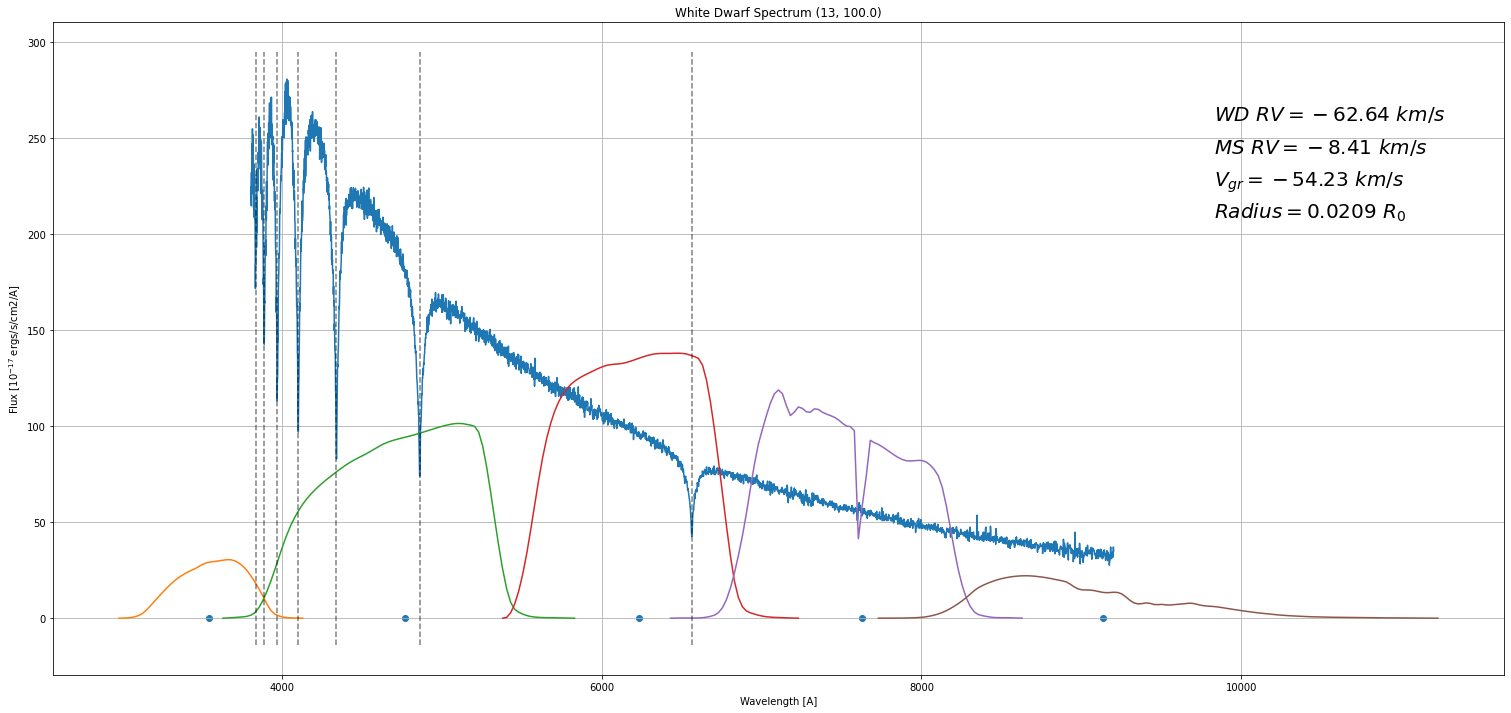

In [34]:
def mag_to_flux(mag):
    return 10 ** ((mag + 48.6)/ -2.5) 

i = 13

balmer_lines = [6562.79, 4861.35, 4340.47, 4101.73, 3970.07, 3889.06, 3835.40]

obs_mag = np.array([catalog[catalog['wd_catalog_id'] == i]['u'][0] - 0.040, catalog[catalog['wd_catalog_id'] == i]['g'][0], catalog[catalog['wd_catalog_id'] == i]['r'][0], catalog[catalog['wd_catalog_id'] == i]['i'][0] + 0.015, catalog[catalog['wd_catalog_id'] == i]['z'][0] + 0.030])
obs_flux = mag_to_flux(obs_mag)


plt.figure(figsize=(26,12))

plt.plot(catalog[catalog['wd_catalog_id'] == i]['wd_wl'][0], catalog[catalog['wd_catalog_id'] == i]['wd_fl'][0])
for filter in filters:
    plt.plot(filter['col1'], filter['col2']*max(catalog[catalog['wd_catalog_id'] == i]['wd_fl'][0]))
min_, max_ = plt.ylim()

sdss_wls = [3543, 4770, 6231, 7625, 9134] # Angstrom
plt.scatter(sdss_wls, obs_flux)

plt.text(0.8, 0.85, r'$WD\ RV = %3.2f$ $km/s$' % (catalog[catalog['wd_catalog_id'] == i]['rv'][0]), transform = plt.gca().transAxes, fontsize=20)
plt.text(0.8, 0.80, r'$MS\ RV = %3.2f$ $km/s$' % (catalog[catalog['wd_catalog_id'] == i]['ms_rv'][0]), transform = plt.gca().transAxes, fontsize=20)
plt.text(0.8, 0.75, r'$V_{gr} = %3.2f$ $km/s$' % (catalog[catalog['wd_catalog_id'] == i]['g_redshift'][0]), transform = plt.gca().transAxes, fontsize=20)
plt.text(0.8, 0.70, r'$Radius = %3.4f$ $R_0$' % (catalog[catalog['wd_catalog_id'] == i]['radius'][0]), transform = plt.gca().transAxes, fontsize=20)

plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)


#plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.grid()
plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
plt.xlabel(r'Wavelength [A]')
plt.title('White Dwarf Spectrum ({}, {})'.format(catalog[catalog['wd_catalog_id'] == i]['wd_catalog_id'][0], catalog[catalog['wd_catalog_id'] == i]['phot_id'][0]))

[6150.3813 6149.122  6147.8633 ... 3806.9517 3805.9697 3804.9897]


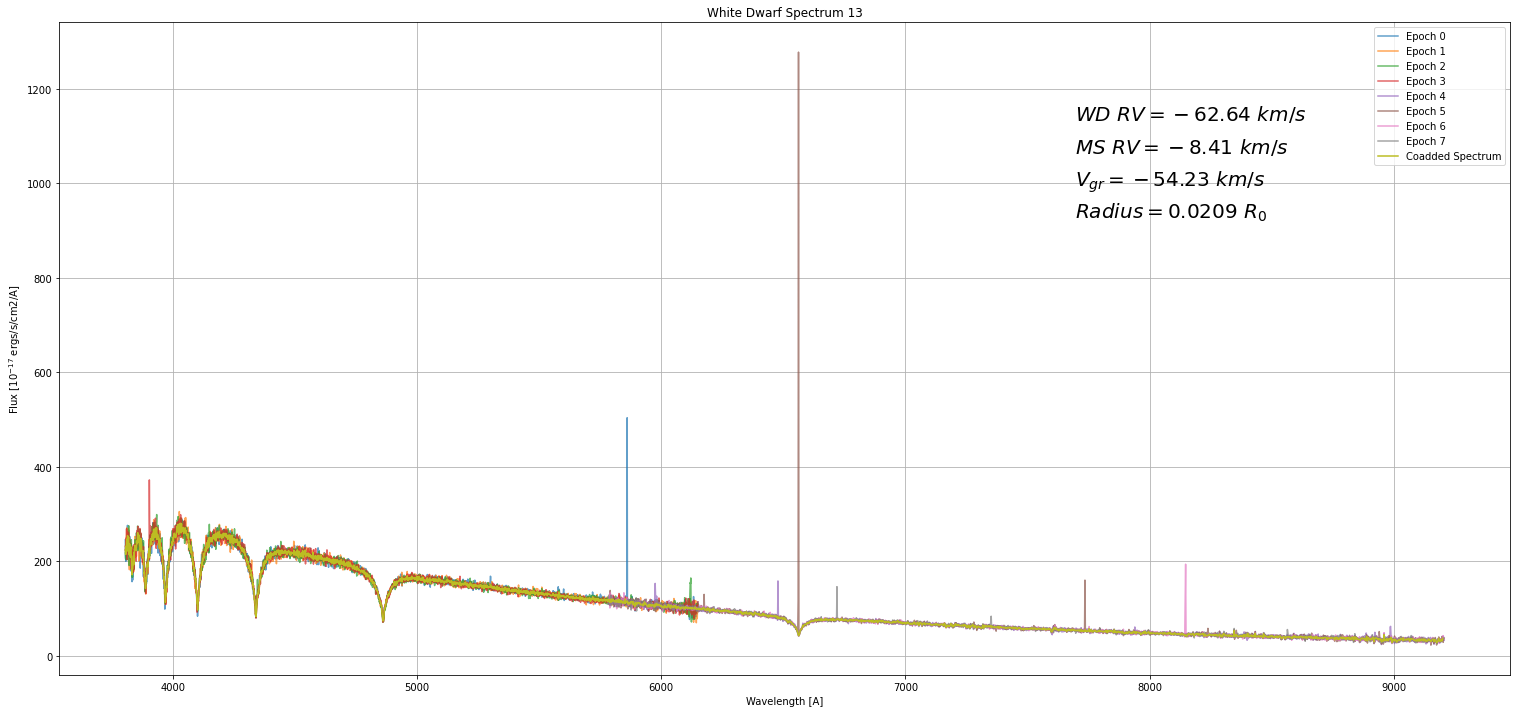

In [35]:
i = 13

obs_mag = np.array([catalog[catalog['wd_catalog_id'] == i]['u'][0] - 0.040, catalog[catalog['wd_catalog_id'] == i]['g'][0], catalog[catalog['wd_catalog_id'] == i]['r'][0], catalog[catalog['wd_catalog_id'] == i]['i'][0] + 0.015, catalog[catalog['wd_catalog_id'] == i]['z'][0] + 0.030])
obs_flux = mag_to_flux(obs_mag)


a = 0
b = -1

plt.figure(figsize=(26,12))

print(catalog[catalog['wd_catalog_id'] == i]['epoch_wls'][0][2])

for j in range(len(catalog[catalog['wd_catalog_id'] == i]['epoch_wls'][0])):
    plt.plot(catalog[catalog['wd_catalog_id'] == i]['epoch_wls'][0][j][a:b], catalog[catalog['wd_catalog_id'] == i]['epoch_fls'][0][j][a:b], alpha = 0.7, label = 'Epoch {}'.format(j))
    
plt.plot(catalog[catalog['wd_catalog_id'] == i]['wd_wl'][0][a:b], catalog[catalog['wd_catalog_id'] == i]['wd_fl'][0][a:b], label = 'Coadded Spectrum')

#for filter in filters:
#    plt.plot(filter['col1'], filter['col2']*max(catalog['wd_fl'][i]))
min_, max_ = plt.ylim()

sdss_wls = [3543, 4770, 6231, 7625, 9134] # Angstrom
#plt.scatter(sdss_wls, obs_flux)

plt.text(0.7, 0.85, r'$WD\ RV = %3.2f$ $km/s$' % (catalog[catalog['wd_catalog_id'] == i]['rv'][0]), transform = plt.gca().transAxes, fontsize=20)
plt.text(0.7, 0.80, r'$MS\ RV = %3.2f$ $km/s$' % (catalog[catalog['wd_catalog_id'] == i]['ms_rv'][0]), transform = plt.gca().transAxes, fontsize=20)
plt.text(0.7, 0.75, r'$V_{gr} = %3.2f$ $km/s$' % (catalog[catalog['wd_catalog_id'] == i]['g_redshift'][0]), transform = plt.gca().transAxes, fontsize=20)
plt.text(0.7, 0.70, r'$Radius = %3.4f$ $R_0$' % (catalog[catalog['wd_catalog_id'] == i]['radius'][0]), transform = plt.gca().transAxes, fontsize=20)


#plt.vlines(balmer_lines, min_, max_, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.grid()
plt.ylabel(r'Flux [$10^{-17}$ ergs/s/cm2/A]')
plt.xlabel(r'Wavelength [A]')
plt.title('White Dwarf Spectrum {}'.format(i))
plt.legend()

<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_5917/743070240.py:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_5917/743070240.py:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_5917/743070240.py:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


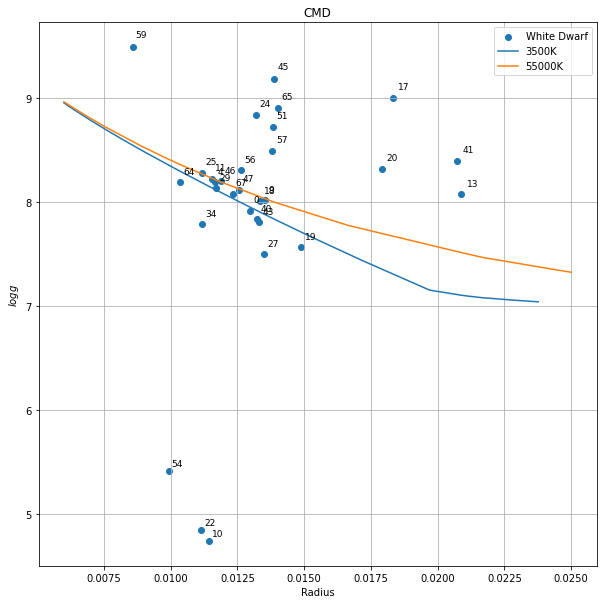

In [36]:
def logg_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_logg = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['logg'], interp_type = 'linear')
    
    logg = rsun_teff_to_logg(radarray, teffarray)
    
    return logg

plt.figure(figsize=(10,10))

rsuns = np.linspace(0.006,0.025, 1000)
theoretical_logg1 = logg_from_radius(rsuns, 3500)
theoretical_logg2 = logg_from_radius(rsuns, 55000)


#plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], label='Main Sequence', s=5)
#plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5)
plt.scatter(catalog['radius'][mask], catalog['corv_logg'][mask], label='White Dwarf')
plt.plot(rsuns, theoretical_logg1, label='3500K')
plt.plot(rsuns, theoretical_logg2, label='55000K')



for i in range(len(catalog['corv_logg'][mask])):
    x = catalog['radius'][mask][i]
    y = catalog['corv_logg'][mask][i]
    #plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][mask][i], fontsize=9)


plt.grid()
plt.ylabel(r'$logg$')
plt.xlabel(r'Radius')
plt.title(r'CMD')
plt.legend()
#plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

In [37]:
poex = np.array([54,22,10,9,45,65,24,51,57,17,20,41,13])

poex_low = np.array([54, 22, 10])
poex_high = np.array([9,45,65,24,51,57,17,20,41,13])

tmask = np.ones(len(catalog))

for i in range(len(catalog)):
    if mask[i] == 0:
        tmask[i] = 0
    elif catalog['wd_catalog_id'][i] in poex_low:
        tmask[i] = 0

In [38]:
tmask = (tmask.astype(bool))

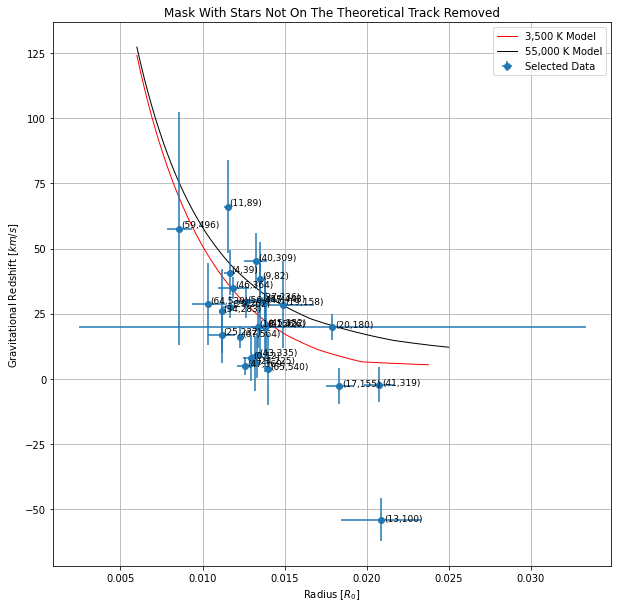

In [39]:
plt.figure(figsize=(10,10))


rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

#plt.plot(rsuns, exp(rsuns, popt[0], popt[1], popt[2]))
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][tmask], catalog['g_redshift_corr'][tmask], xerr = catalog['e_radius'][tmask], yerr=catalog['eg_redshift'][tmask], fmt='o', label = 'Selected Data')

for i in range(len(catalog['radius'][tmask])):
    x = catalog['radius'][tmask][i]
    y = catalog['g_redshift'][tmask][i]
    #plt.plot(x, y, 'bo')
    
    #if (0.006 < x < 0.025) and (-30 < y < 120):
    #    plt.text(x * (1 + 0.01), y * (1 + 0.01) , '(' + str(catalog['wd_catalog_id'][tmask][i]) + ',' + str(int(catalog['phot_id'][tmask][i])) + ')', fontsize=9)
    
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , '(' + str(catalog['wd_catalog_id'][tmask][i]) + ',' + str(int(catalog['phot_id'][tmask][i])) + ')', fontsize=9)

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.025)
#plt.ylim(-30, 120)
plt.title('Mask With Stars Not On The Theoretical Track Removed')
plt.legend()

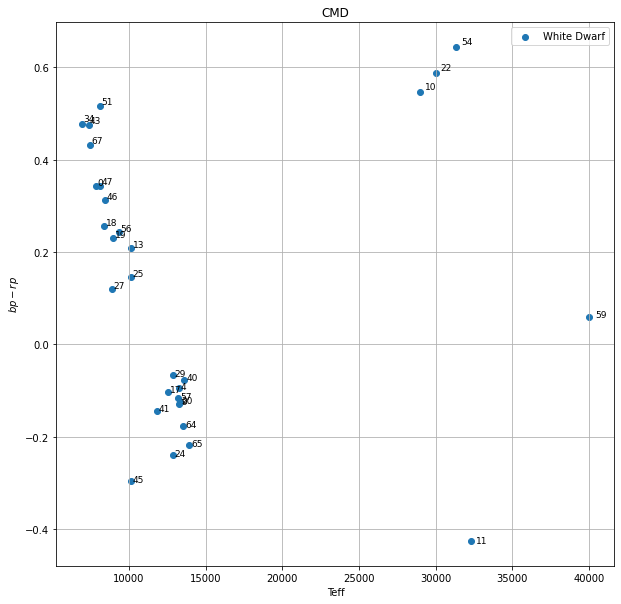

In [41]:
plt.figure(figsize=(10,10))

rsuns = np.linspace(0.006,0.025, 1000)
theoretical_logg1 = logg_from_radius(rsuns, 3500)
theoretical_logg2 = logg_from_radius(rsuns, 55000)


#plt.scatter(catalog['ms_bp_rp'][mask], catalog['ms_m_g'][mask], label='Main Sequence', s=5)
#plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5)
plt.scatter(catalog['corv_teff'][mask], catalog['wd_bp_rp'][mask], label='White Dwarf')
#plt.plot(rsuns, theoretical_logg1, label='3500K')
#plt.plot(rsuns, theoretical_logg2, label='55000K')



for i in range(len(catalog['corv_logg'][mask])):
    x = catalog['corv_teff'][mask][i]
    y = catalog['wd_bp_rp'][mask][i]
    #plt.plot(x, y, 'bo')
    plt.text(x * (1 + 0.01), y * (1 + 0.01) , catalog['wd_catalog_id'][mask][i], fontsize=9)


plt.grid()
plt.ylabel(r'$bp-rp$')
plt.xlabel(r'Teff')
plt.title(r'CMD')
plt.legend()
#plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()